라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = ['Test230718_tank1_lstm_all', 'Test230717_tank1_lstm_crop_only-feed_no180', 'Test230721_tank1_lstm_crop720_only-feed']

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


/tmp/ipykernel_4183582/778596347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
/tmp/ipykernel_4183582/778596347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
/tmp/ipykernel_4183582/778596347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_validation_features_X_a = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

모델 평가

In [58]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('x')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva4(y_test, X_test_shape, y_test_shape, feed):
    X_pred = []
    model = []
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
        X_pred.append(model[i].predict(X_test_shape[i]))
        X_pred[i] = np.asarray(X_pred[i], dtype=np.float64)
        X_pred[i] = X_pred[i].reshape((-1))
        print(len( X_pred[i]))
        if len( X_pred[i]) > len(y_test):
            x = len( X_pred[i]) - len(y_test)
            X_pred[i] = X_pred[i][x:]

        # 그래프 생성
        plt.figure(figsize=(15, 7))
        plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
        plt.plot(y_test.index, X_pred[i], color='red', label='prediction do')  # x축에 년월일, y축에 시분
        plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
        plt.xlabel('date')
        plt.ylabel('do')
        plt.title(model_name[i])
        plt.legend(['sensor do','prediction do','feed_quantity'])
        plt.show()
    
        # 평가 생성
        result = model[i].evaluate(X_test_shape[i], y_test_shape[i])
        print("MSE // MAE // R-squared ", result)
    
    
    final_predictions = (X_pred[0] + X_pred[1] + X_pred[2])/3
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('average')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = X_pred[0] * (X_pred[1] / 8.50096798)
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred[1], label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred[2], color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('pred')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = ((X_pred[0] * (X_pred[1] / 8.50096798)) + X_pred[2])/2
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    final_predictions = X_pred[0] * (X_pred[1] / 8.50096798) * (X_pred[2] / 8.50096798)
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = (X_pred[1] / 8.50096798) * X_pred[2]
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

In [59]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

nCar: 63180 nVar: 1
nCar: 351 nVar: 180
nCar: 63180 nVar: 1
nCar: 88 nVar: 720


In [60]:
X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 9
nCar: 351 nVar: 9


In [61]:
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 63180 nVar: 1


In [62]:
X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 88 nVar: 1
nCar: 88 nVar: 1


In [63]:
X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

63180


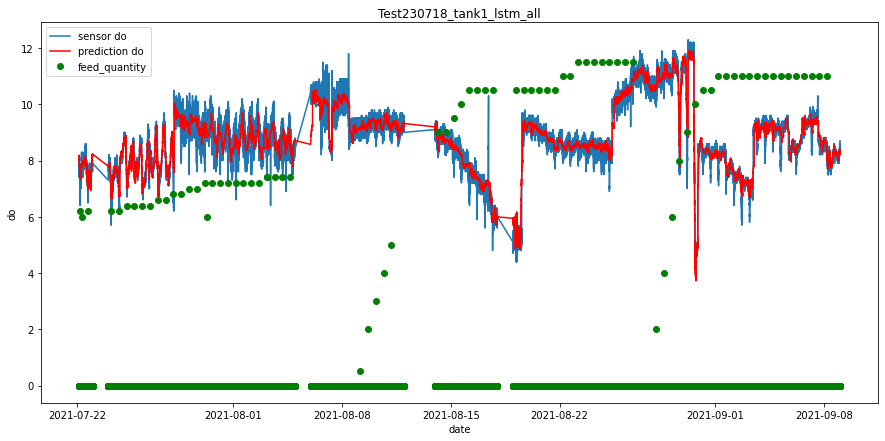

11/11 [==============================] - 2s 18ms/step - loss: 0.1327 - mae: 0.2554 - r_squared: 0.7279
MSE // MAE // R-squared  [0.1326988935470581, 0.25536486506462097, 0.7279142737388611]
63180


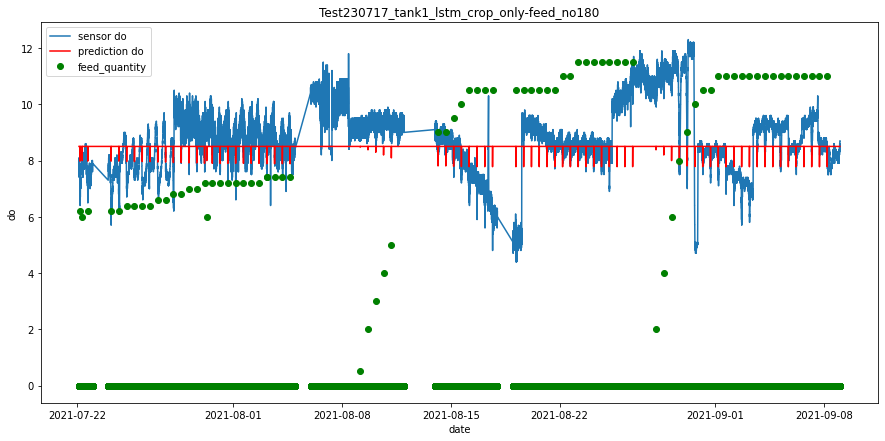

1975/1975 [==============================] - 15s 7ms/step - loss: 1.5664 - mae: 0.9319 - r_squared: -103.9913
MSE // MAE // R-squared  [1.56636381149292, 0.9318777918815613, -103.99129486083984]
63360


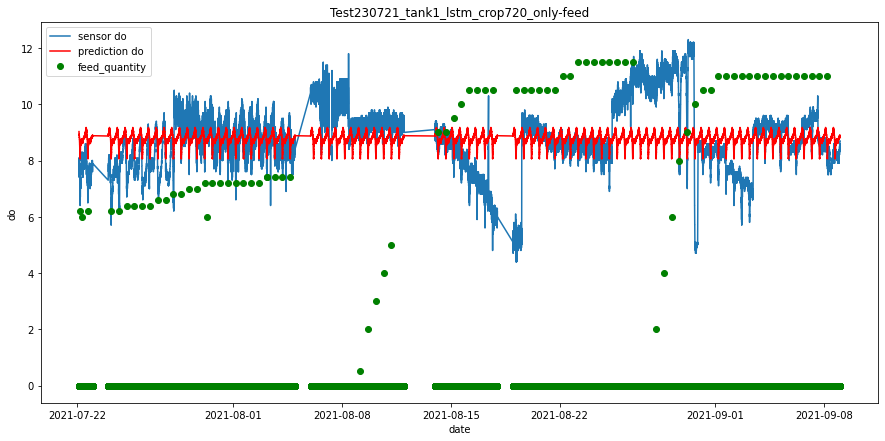

3/3 [==============================] - 1s 41ms/step - loss: 1.6505 - mae: 0.9103 - r_squared: 0.0171
MSE // MAE // R-squared  [1.6504849195480347, 0.9103260636329651, 0.017115673050284386]


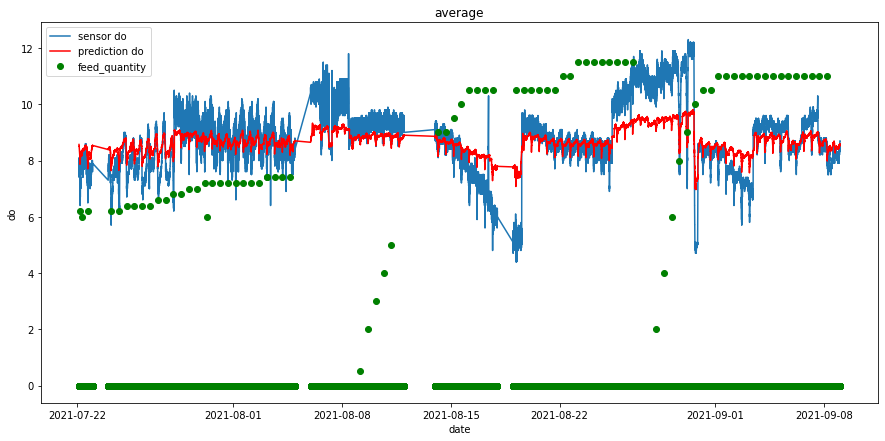

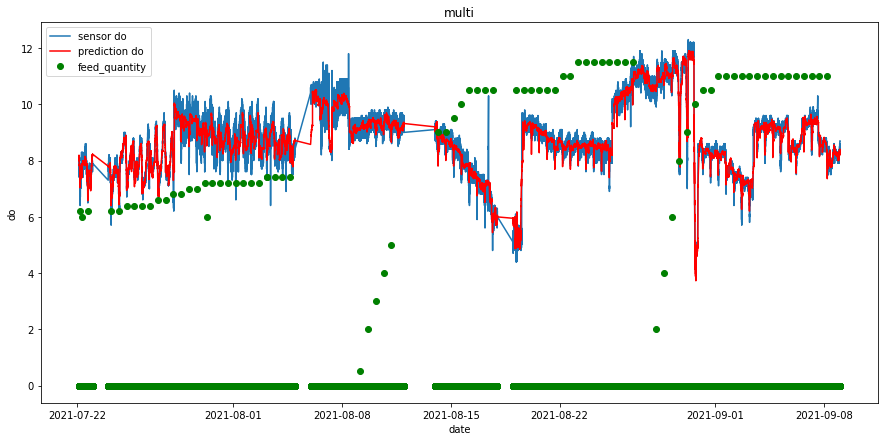

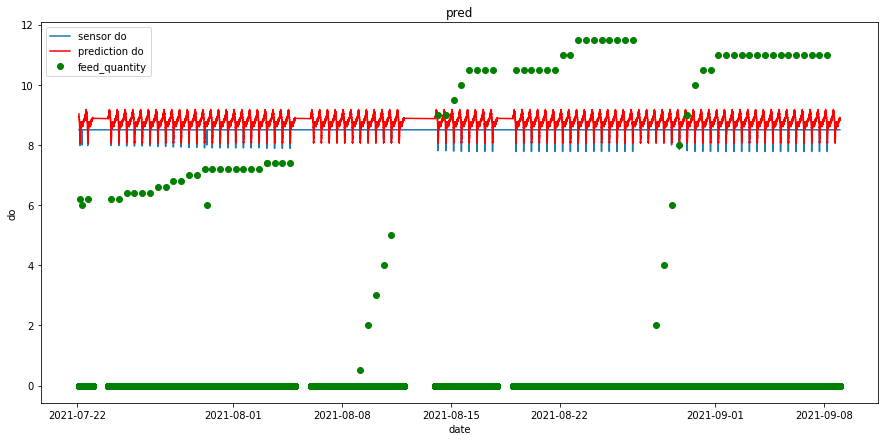

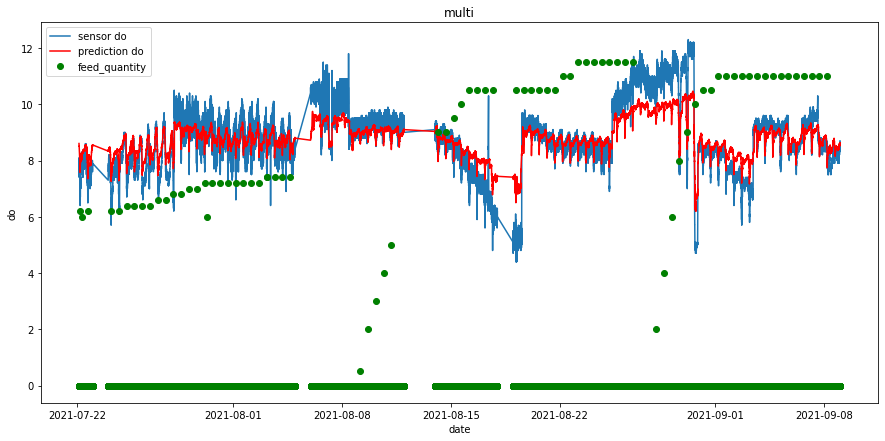

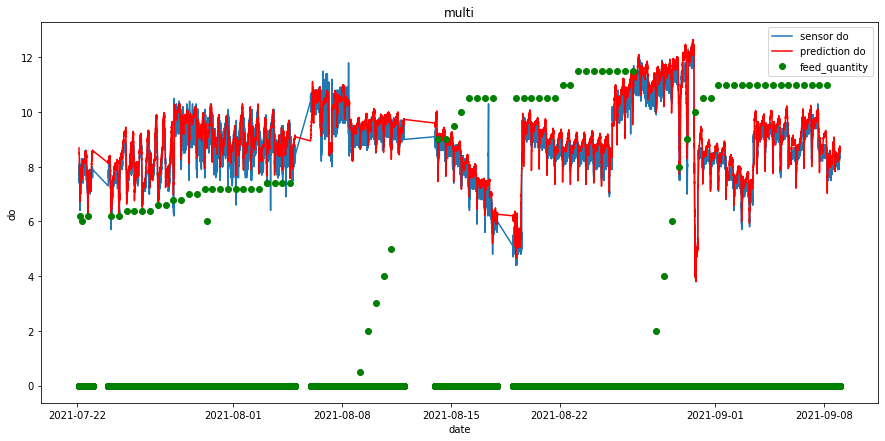

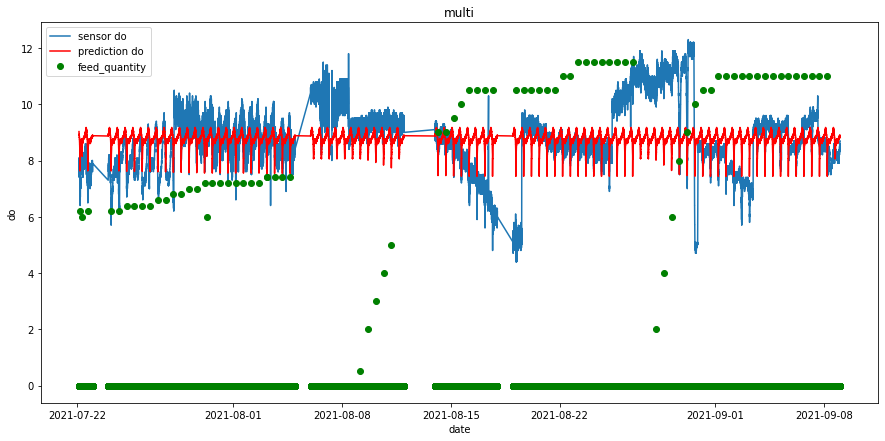

In [64]:
grapeNEva4(y_test, X_test_shape, y_test_shape, X_test2[['feed_quantity']])

nCar: 12780 nVar: 1
nCar: 71 nVar: 180
nCar: 12780 nVar: 1
nCar: 18 nVar: 720
nCar: 71 nVar: 9
nCar: 71 nVar: 9
nCar: 12780 nVar: 1
nCar: 12780 nVar: 1
nCar: 18 nVar: 1
nCar: 18 nVar: 1
12780


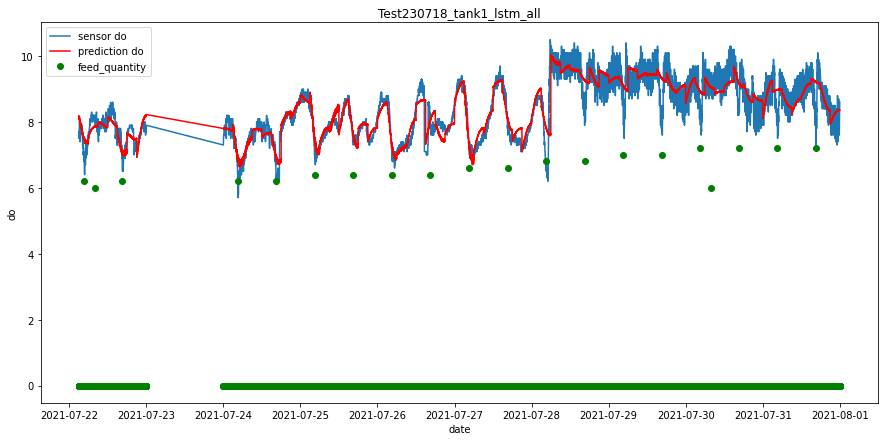

3/3 [==============================] - 1s 15ms/step - loss: 0.1477 - mae: 0.2761 - r_squared: 0.5790
MSE // MAE // R-squared  [0.14773279428482056, 0.27614501118659973, 0.578962504863739]
12780


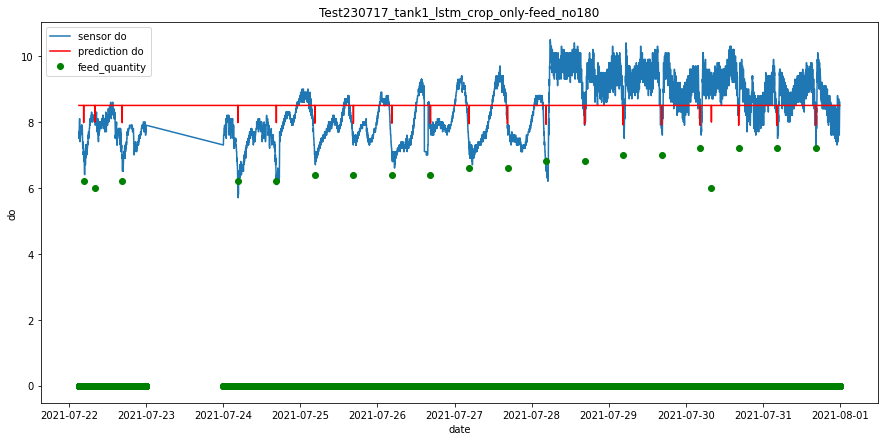

400/400 [==============================] - 4s 6ms/step - loss: 0.7763 - mae: 0.7523 - r_squared: -80.4016
MSE // MAE // R-squared  [0.7763113379478455, 0.7523468136787415, -80.4015884399414]
12960


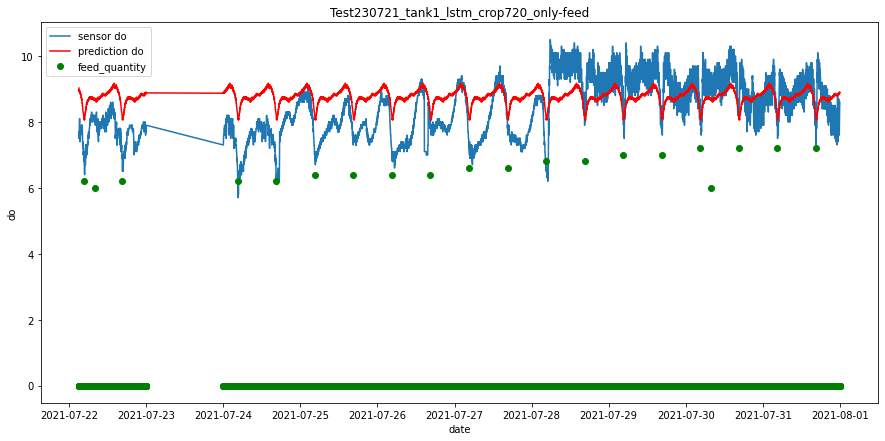

1/1 [==============================] - 2s 2s/step - loss: 1.9116 - mae: 0.8700 - r_squared: -0.1100
MSE // MAE // R-squared  [1.9115967750549316, 0.8700213432312012, -0.1099541187286377]


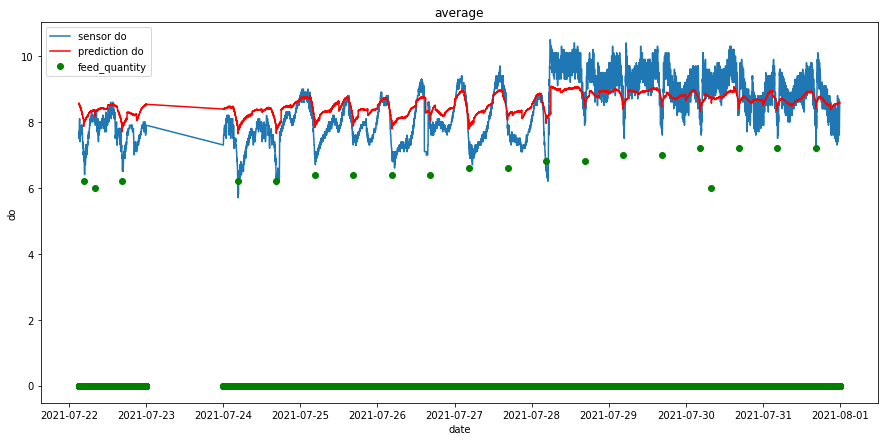

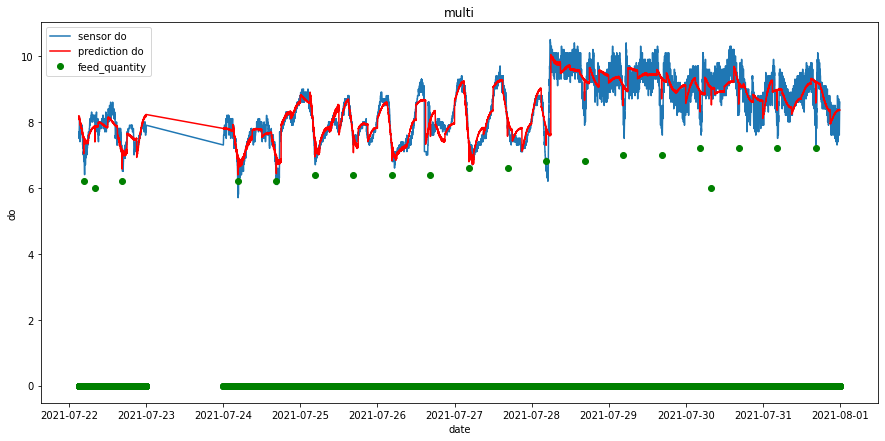

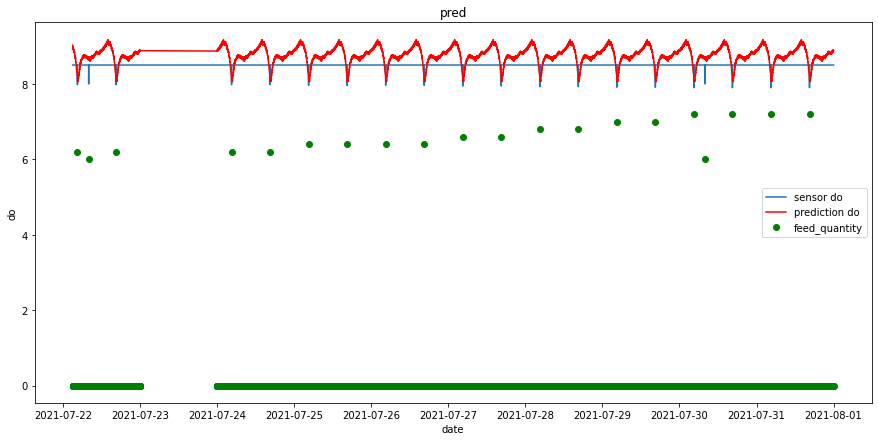

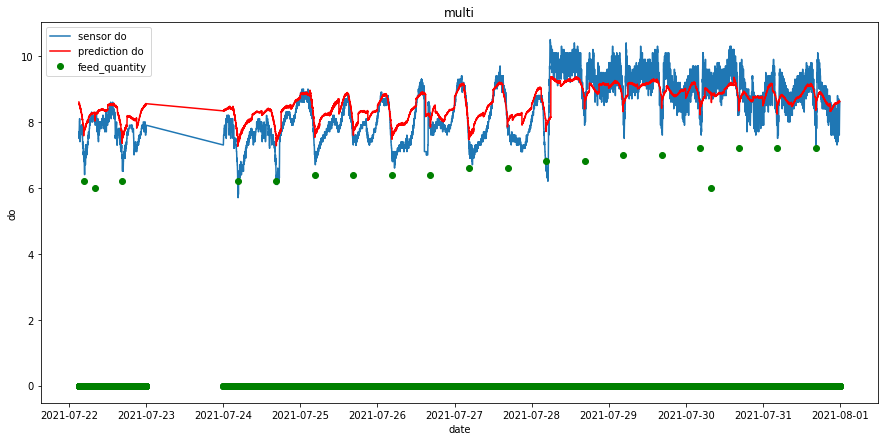

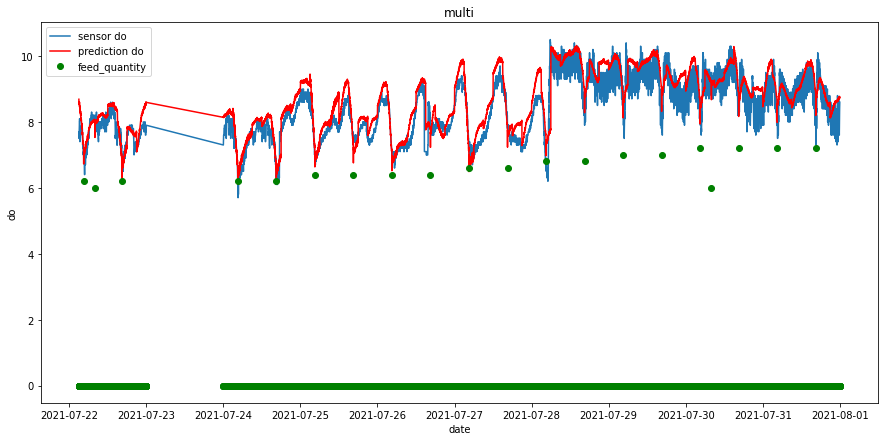

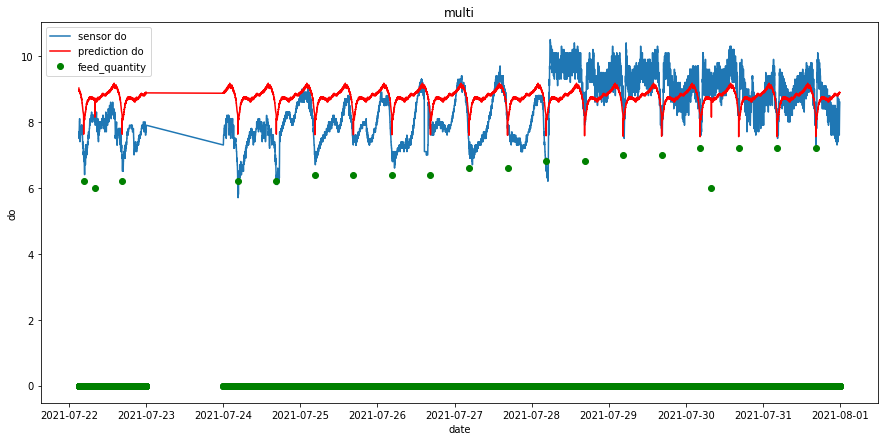

In [65]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-31 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

grapeNEva4(y_test, X_test_shape, y_test_shape, X_test2[['feed_quantity']])

nCar: 1260 nVar: 1
nCar: 7 nVar: 180
nCar: 1260 nVar: 1
nCar: 2 nVar: 720
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
1260


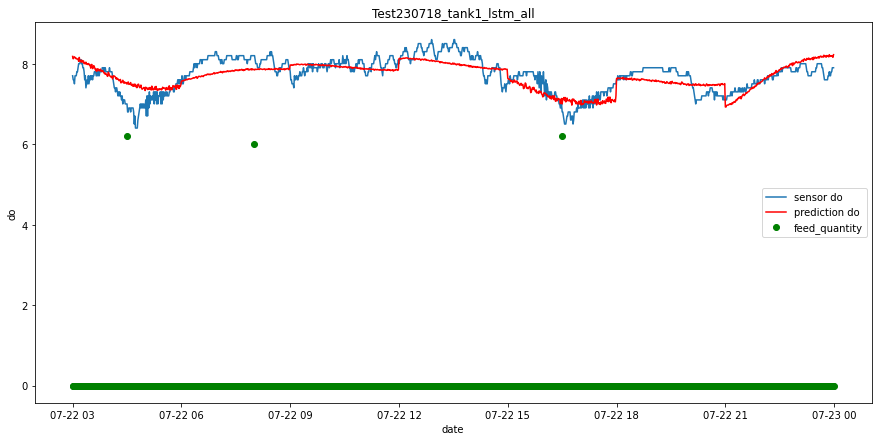

1/1 [==============================] - 1s 1s/step - loss: 0.0791 - mae: 0.2305 - r_squared: 0.5583
MSE // MAE // R-squared  [0.07908868044614792, 0.2305183708667755, 0.5582667589187622]
1260


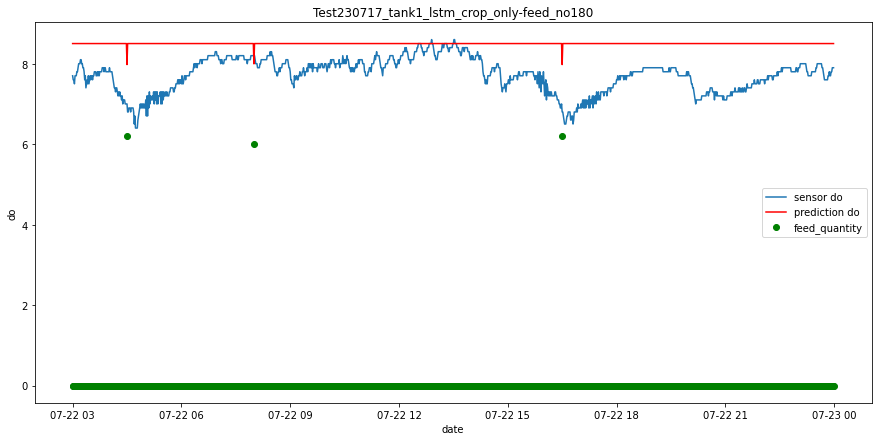

40/40 [==============================] - 1s 6ms/step - loss: 0.7820 - mae: 0.7775 - r_squared: -69.6556
MSE // MAE // R-squared  [0.7819896340370178, 0.7775168418884277, -69.65557861328125]
1440


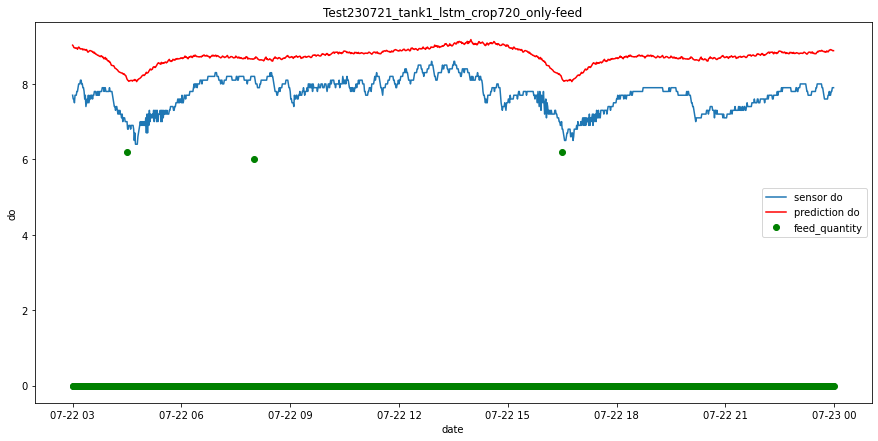

1/1 [==============================] - 1s 1s/step - loss: 11.1213 - mae: 2.0060 - r_squared: -0.6648
MSE // MAE // R-squared  [11.121280670166016, 2.0059947967529297, -0.664779782295227]


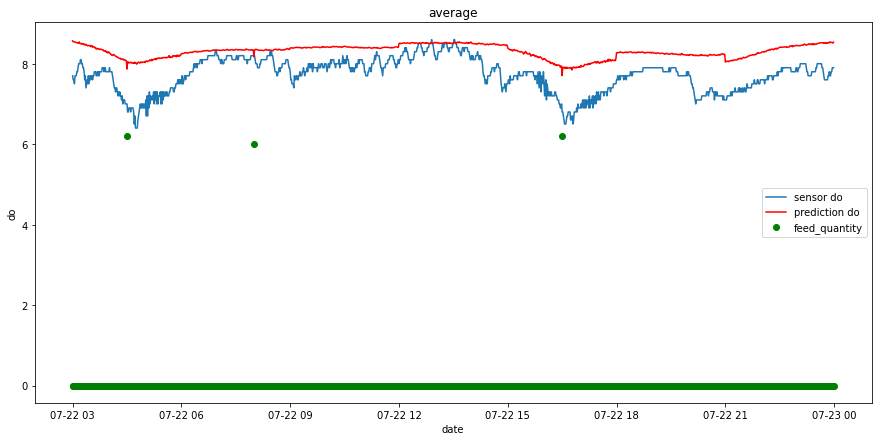

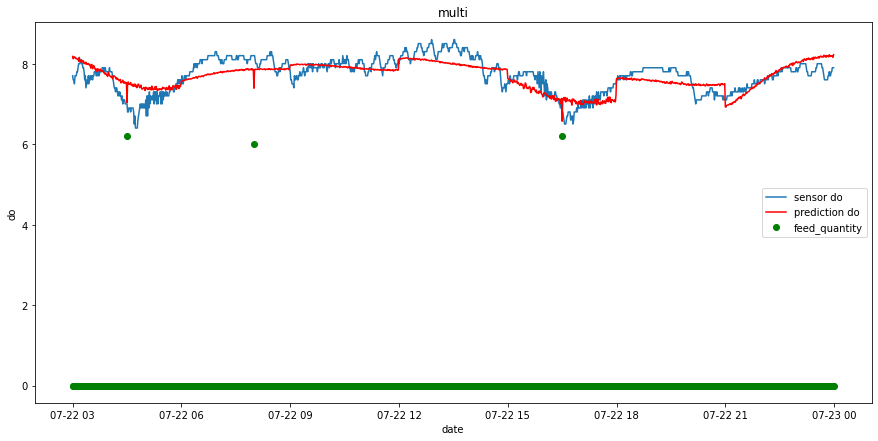

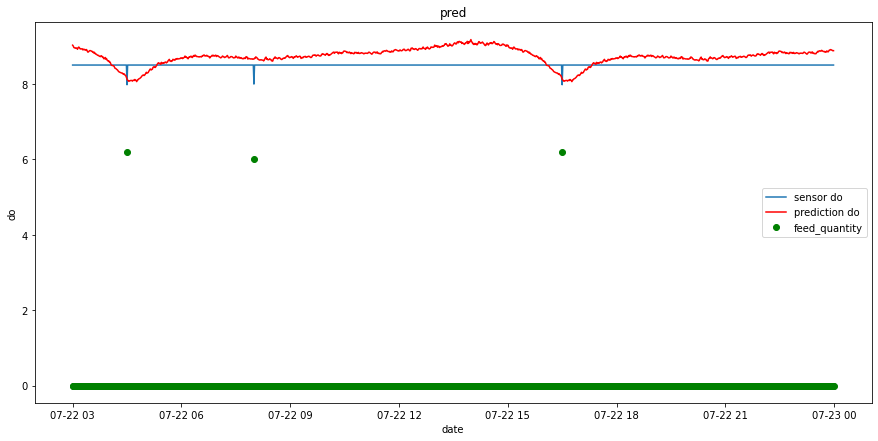

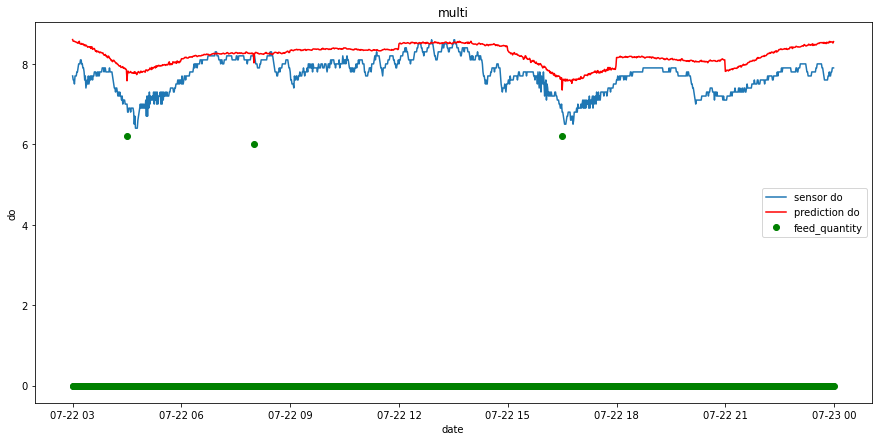

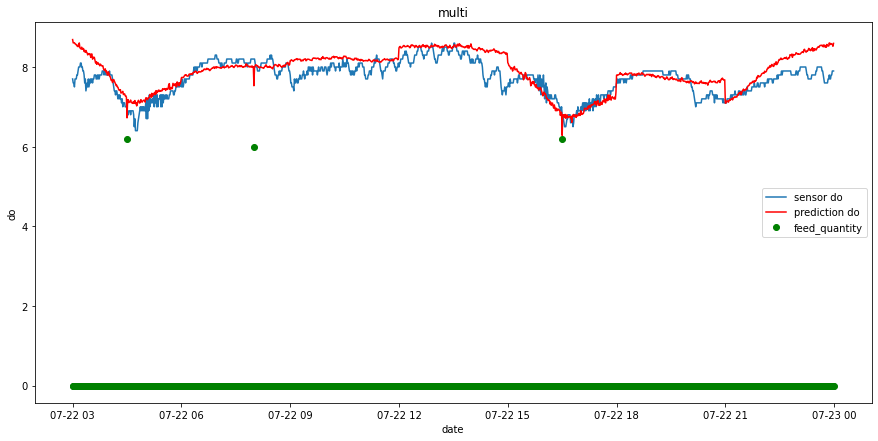

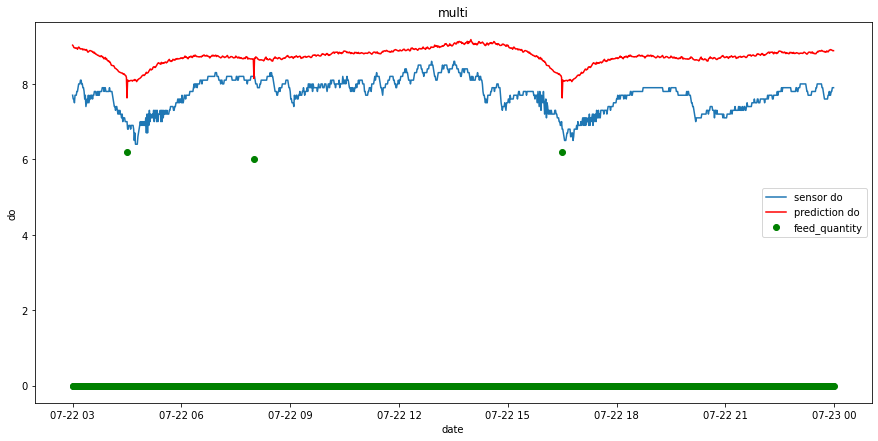

In [66]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

grapeNEva4(y_test, X_test_shape, y_test_shape, X_test2[['feed_quantity']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


nCar: 1260 nVar: 1
nCar: 7 nVar: 180
nCar: 1260 nVar: 1
nCar: 2 nVar: 720
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
1260


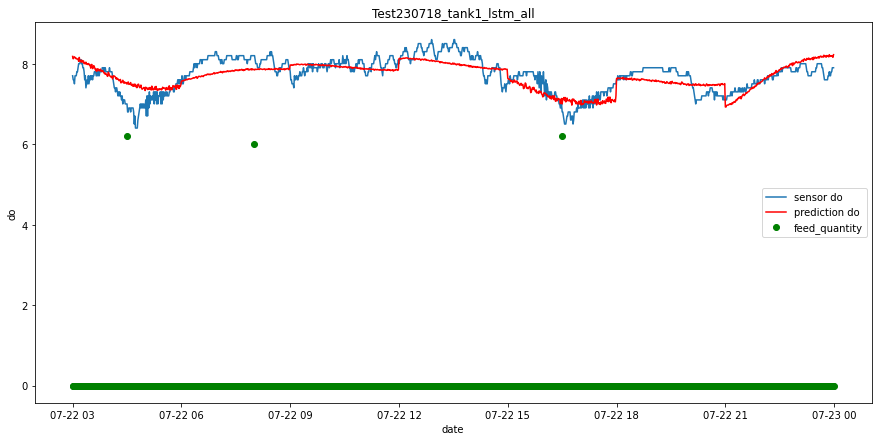

1/1 [==============================] - 1s 1s/step - loss: 0.0791 - mae: 0.2305 - r_squared: 0.5583
MSE // MAE // R-squared  [0.07908868044614792, 0.2305183708667755, 0.5582667589187622]
1260


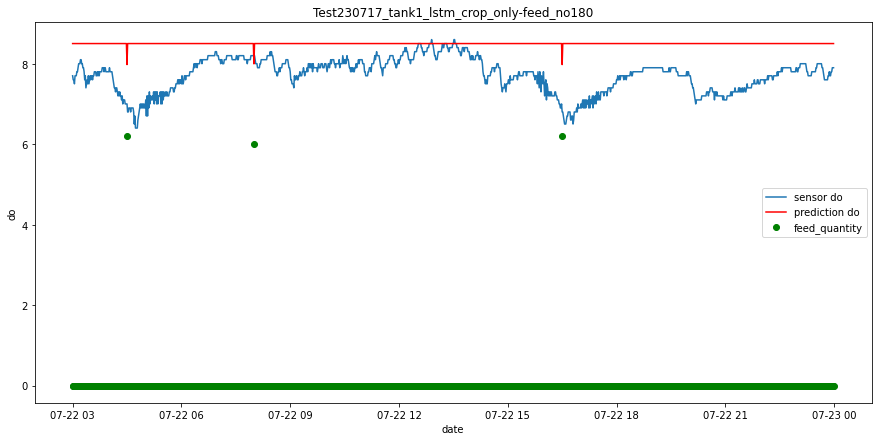

40/40 [==============================] - 1s 6ms/step - loss: 0.7820 - mae: 0.7775 - r_squared: -69.6556
MSE // MAE // R-squared  [0.7819896340370178, 0.7775168418884277, -69.65557861328125]
1440


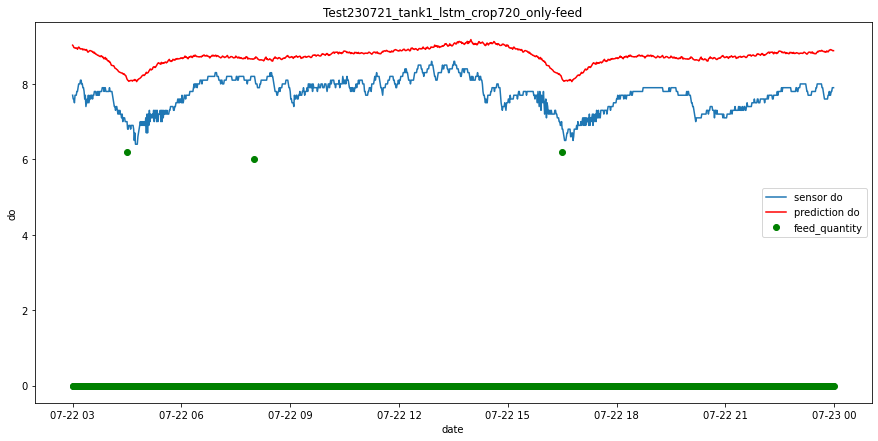

1/1 [==============================] - 1s 908ms/step - loss: 11.1213 - mae: 2.0060 - r_squared: -0.6648
MSE // MAE // R-squared  [11.121280670166016, 2.0059947967529297, -0.664779782295227]


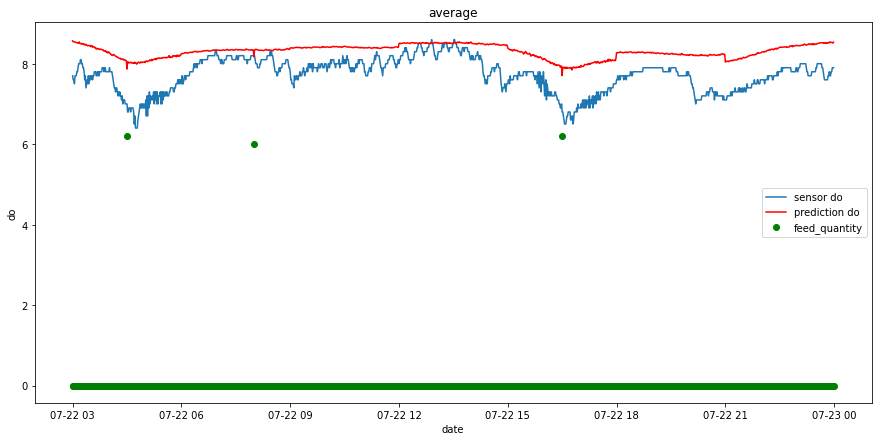

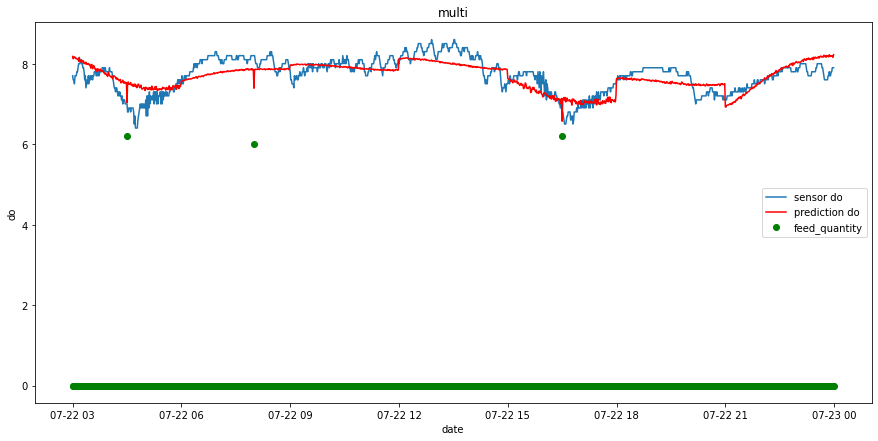

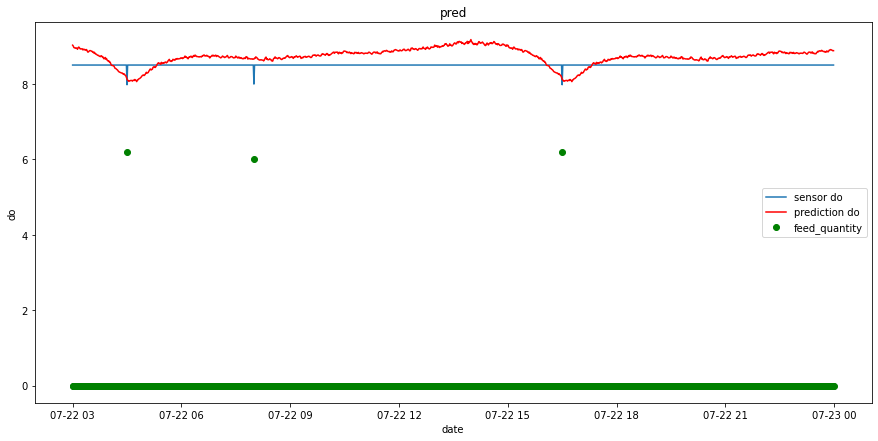

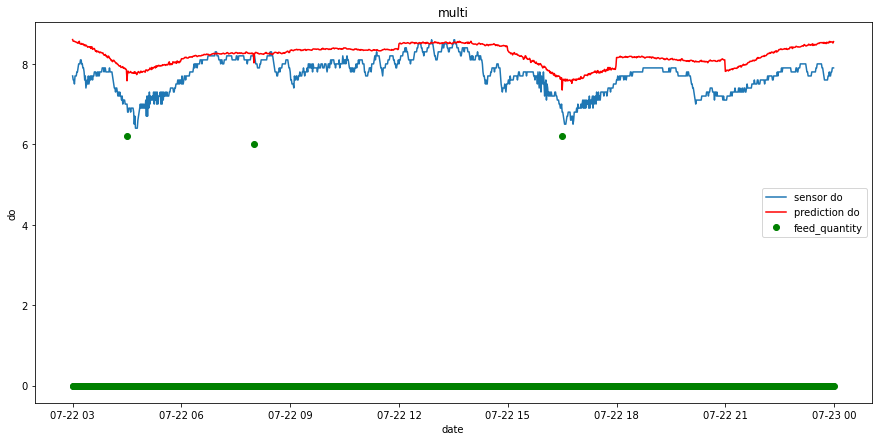

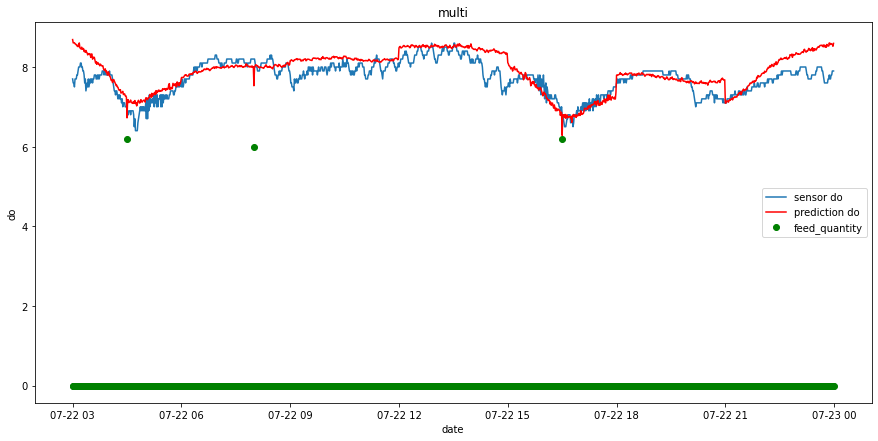

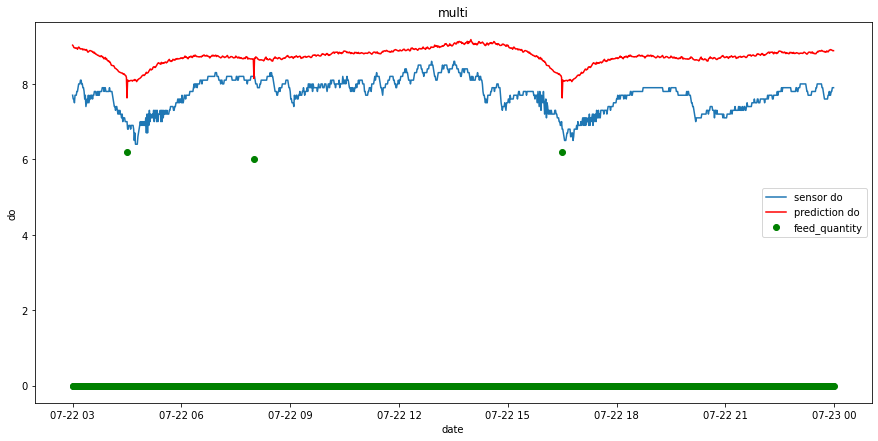

In [67]:
japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

grapeNEva4(y_test, X_test_shape, y_test_shape, X_test2[['feed_quantity']])

nCar: 1260 nVar: 1
nCar: 7 nVar: 180
nCar: 1260 nVar: 1
nCar: 2 nVar: 720
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
1260


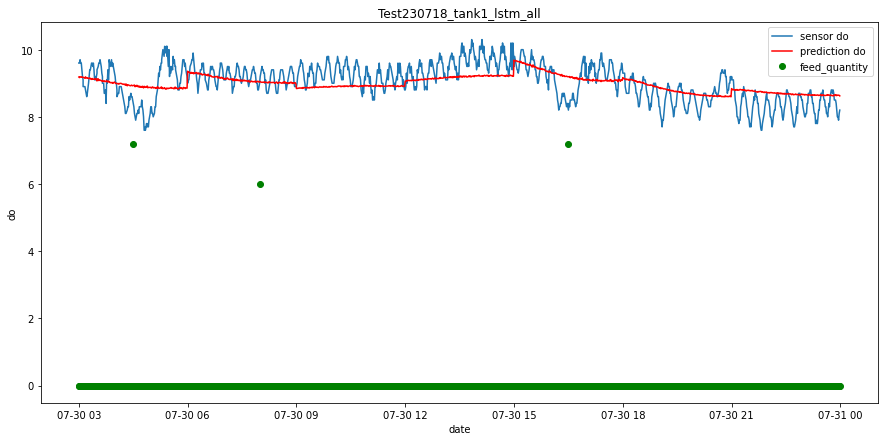

1/1 [==============================] - 1s 1s/step - loss: 0.2202 - mae: 0.3788 - r_squared: 0.2924
MSE // MAE // R-squared  [0.22022883594036102, 0.3787845969200134, 0.29236024618148804]
1260


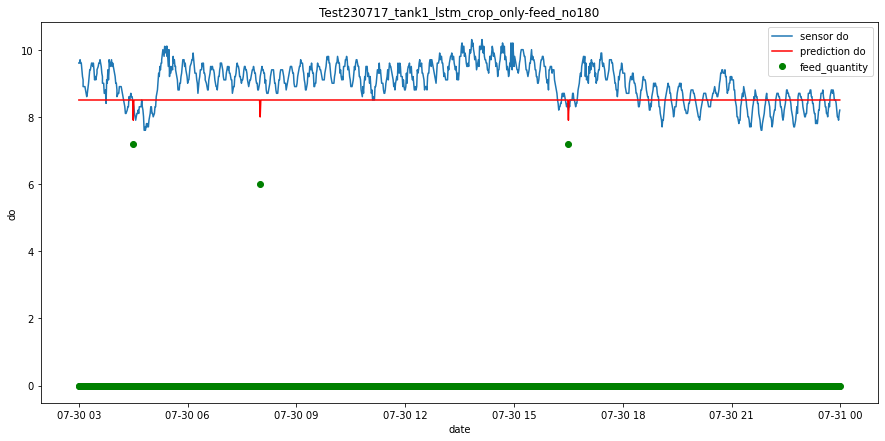

40/40 [==============================] - 1s 6ms/step - loss: 0.5898 - mae: 0.6553 - r_squared: -6.8024
MSE // MAE // R-squared  [0.5897817611694336, 0.6553146839141846, -6.802432060241699]
1440


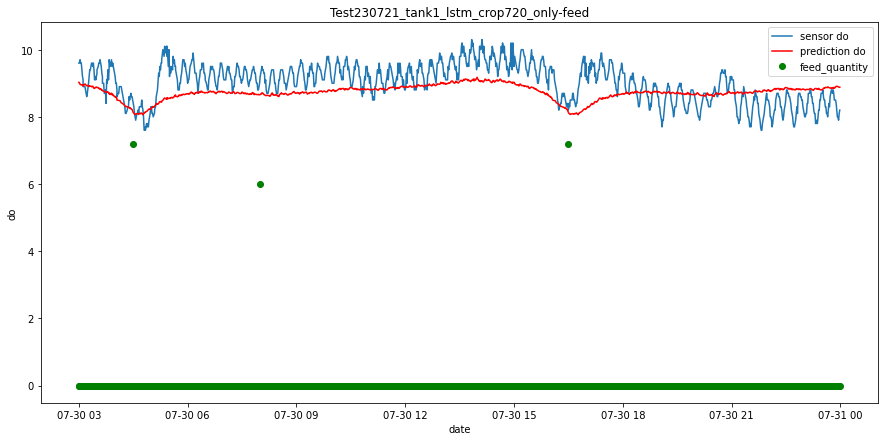

1/1 [==============================] - 1s 1s/step - loss: 10.4736 - mae: 1.5678 - r_squared: -0.1401
MSE // MAE // R-squared  [10.473594665527344, 1.5678492784500122, -0.1400926113128662]


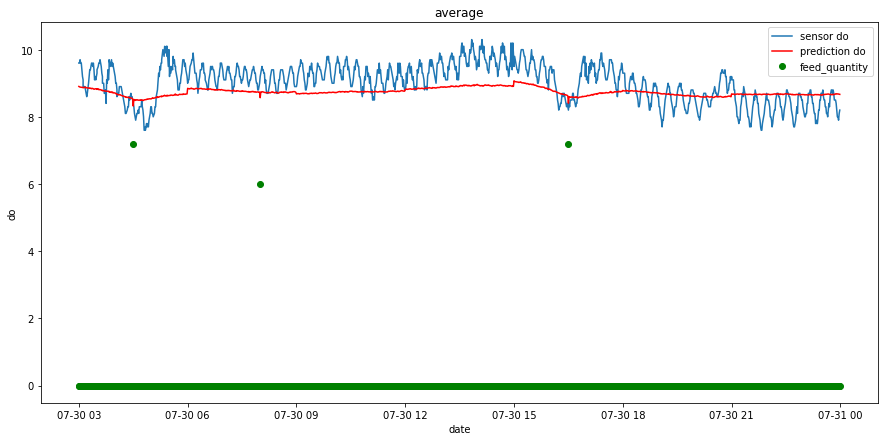

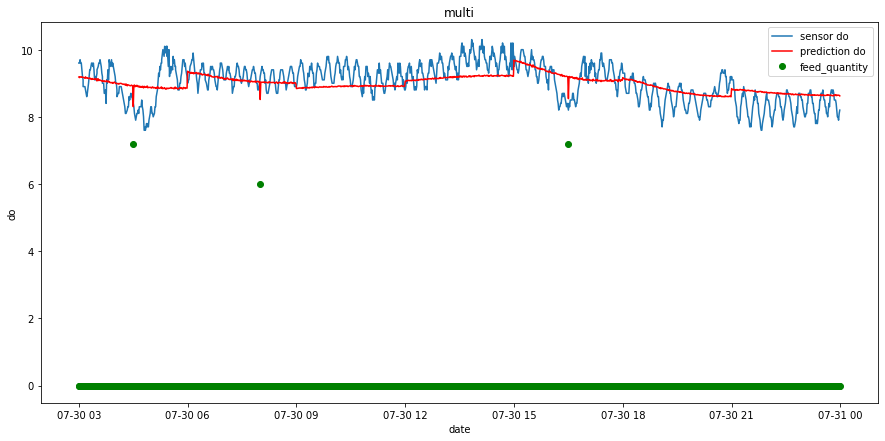

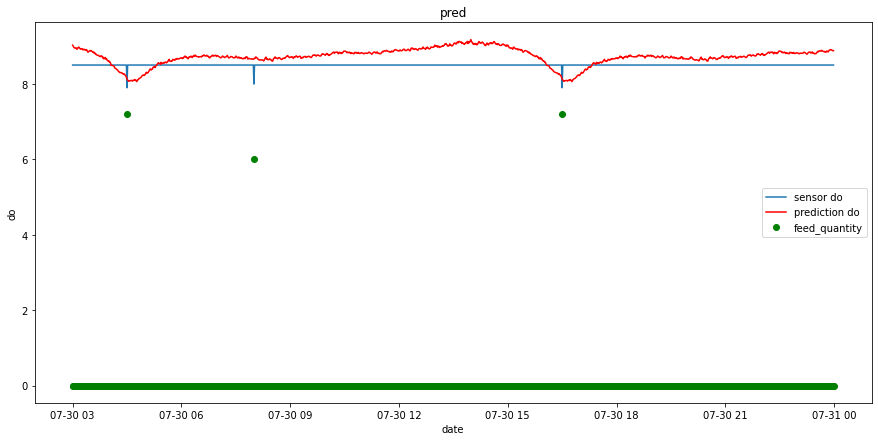

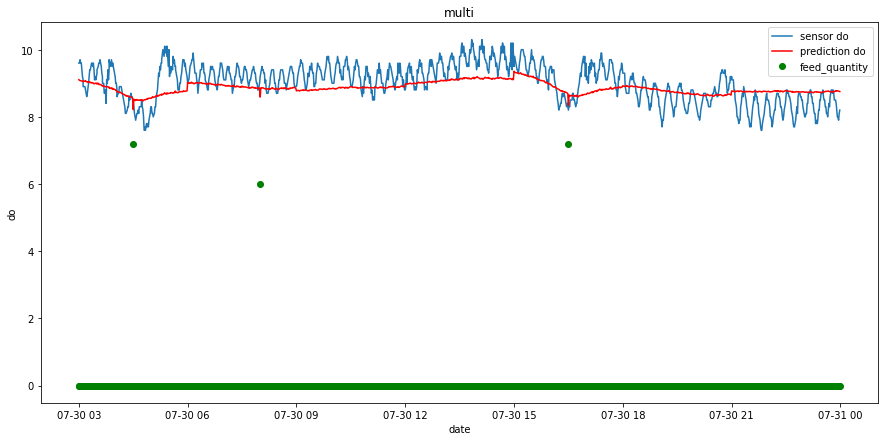

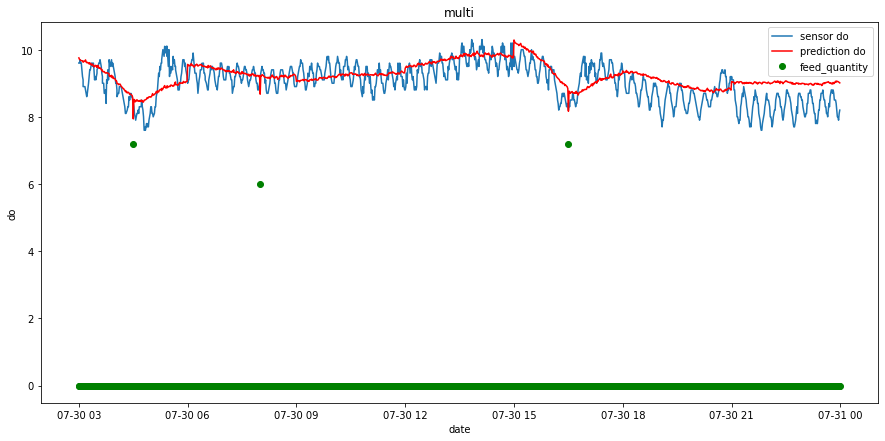

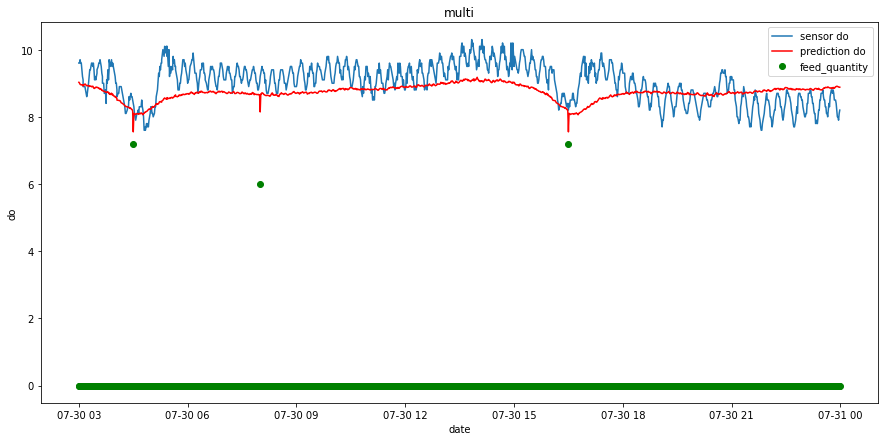

In [68]:
y_date = japonica_validation_features_y.loc['2021-07-30 03:00':'2021-07-30 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

X_test1 = japonica_validation_features_X_a.loc['2021-07-30 00:00':'2021-07-30 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

grapeNEva4(y_test, X_test_shape, y_test_shape, X_test2[['feed_quantity']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


nCar: 1260 nVar: 1
nCar: 7 nVar: 180
nCar: 1260 nVar: 1
nCar: 2 nVar: 720
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
1260


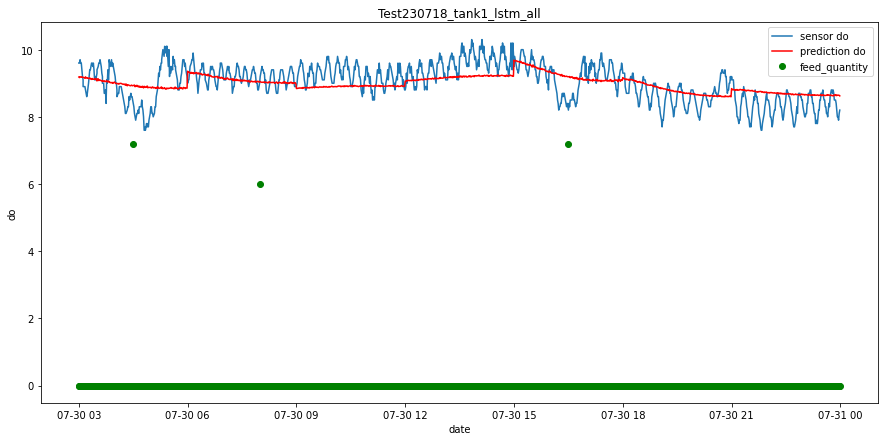

1/1 [==============================] - 1s 1s/step - loss: 0.2202 - mae: 0.3788 - r_squared: 0.2924
MSE // MAE // R-squared  [0.22022883594036102, 0.3787845969200134, 0.29236024618148804]
1260


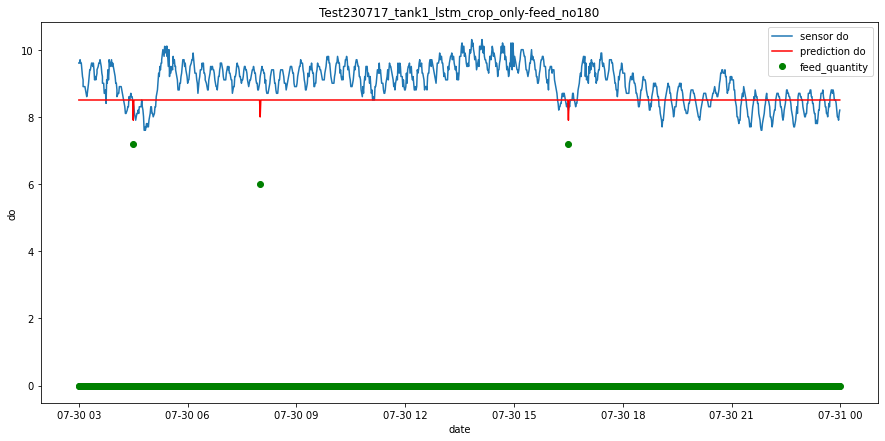

40/40 [==============================] - 1s 6ms/step - loss: 0.5898 - mae: 0.6553 - r_squared: -6.8024
MSE // MAE // R-squared  [0.5897817611694336, 0.6553146839141846, -6.802432060241699]
1440


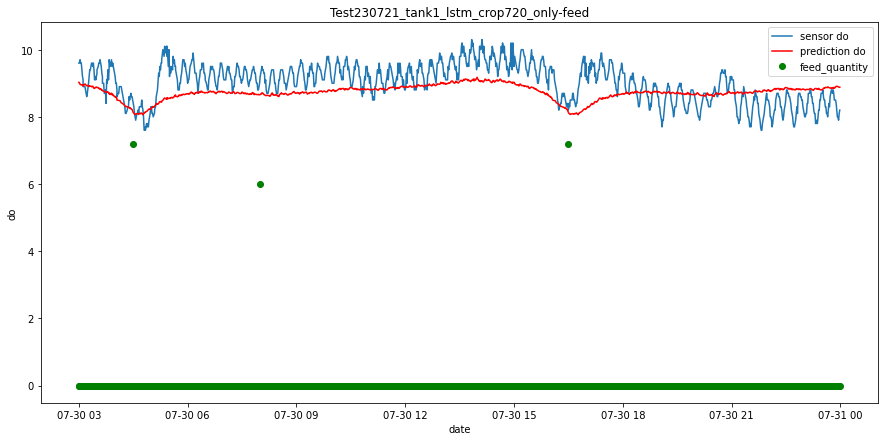

1/1 [==============================] - 2s 2s/step - loss: 10.4736 - mae: 1.5678 - r_squared: -0.1401
MSE // MAE // R-squared  [10.473594665527344, 1.5678492784500122, -0.1400926113128662]


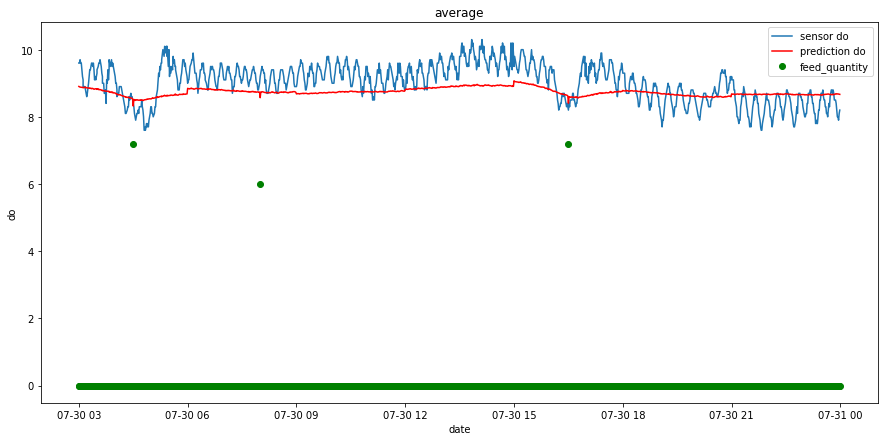

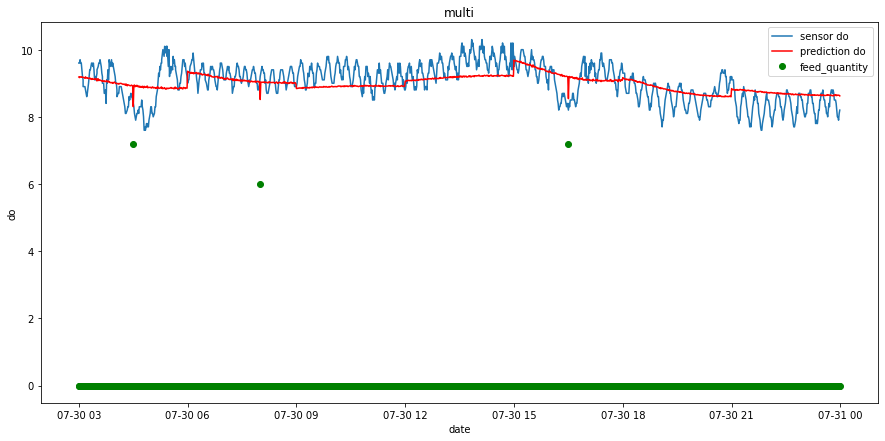

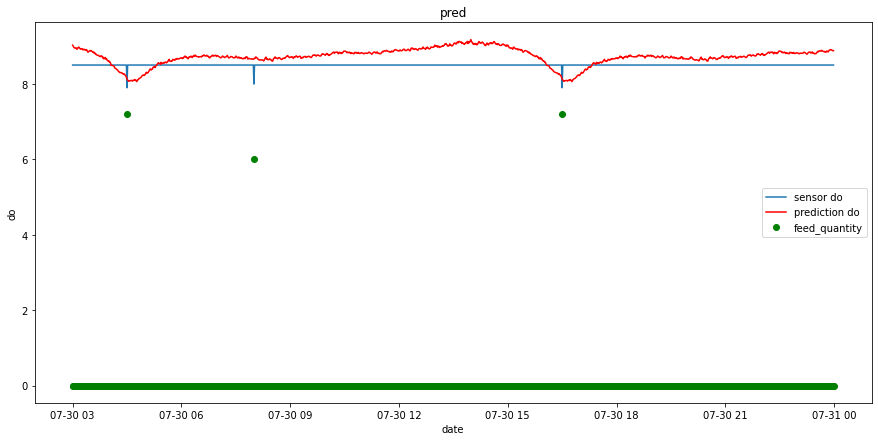

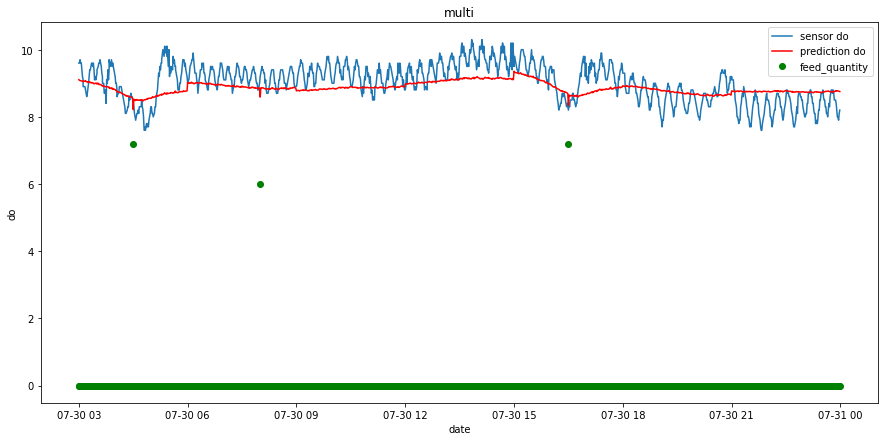

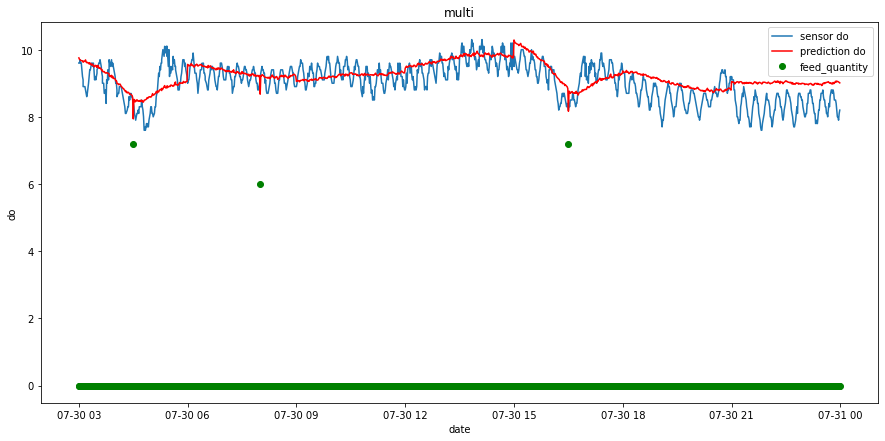

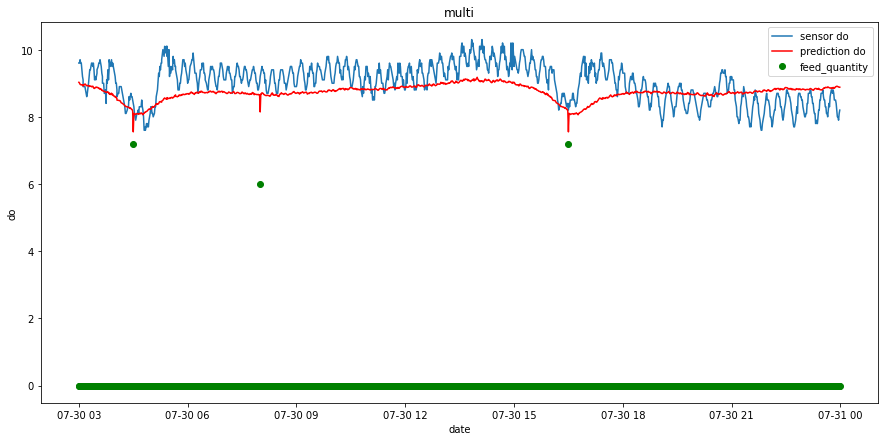

In [69]:
japonica_validation_features_X_a.at['2021-07-30 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-30 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-30 03:00':'2021-07-30 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

X_test1 = japonica_validation_features_X_a.loc['2021-07-30 00:00':'2021-07-30 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

grapeNEva4(y_test, X_test_shape, y_test_shape, X_test2[['feed_quantity']])

In [ ]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))

zero_padding = np.zeros((180, 1), dtype=np.float64)
y_test_reshape3 = np.concatenate([zero_padding, y_test_reshape], axis=0)
y_test_reshape3 = y_test_reshape3.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape3.shape[0] # 데이터 개수
nVar = y_test_reshape3.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test_shape = [y_test_reshape1, y_test_reshape2, y_test_reshape3]

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )